In [1]:
import random
import math
import numpy as np
import scipy.stats as stats
import statistics
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
plt.style.use('ggplot')




In [2]:
def rw2(n):# save the headings not the pairs
    #x,y=0,0
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        #x+=r*math.cos(theta[i])
        #y+=r*math.sin(theta[i])
    return theta 
n=100 #int(input("how many steps?"))
alpha=2 #int(input("what's the scale?"))
beta=5 #int(input("what's the shape?"))
c=0.9# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
#tries=int(input("how many tries?"))
#for i in range(tries):
    #print(rw2(n))
data=rw2(n)
#data

In [3]:
# modify the data so I can have the differences in the heading
#data[1]=data[1]-data[0] etc.
new_data=np.zeros(n)
new_data[0]=data[0]
for i in range(len(data)-1):
    new_data[i+1]=data[i+1]-data[i]# I can only put positive values in the MCMC sampler
    if new_data[i+1]<0:
        new_data[i+1]=new_data[i+1]+2*math.pi
for i in range(len(new_data)):
    if new_data[i]<0 or new_data[i]>2*math.pi:
        print("try again big man")# seems to be working
    

In [4]:
# calculate the log likelihood of wrapcauchy
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter
    

In [5]:
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A = [guess]
# define stepsize of MCMC.
stepsize = 0.035  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 10,000 iterations.
for p in range(10000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))
#print(A)


Acceptance rate = 0.3917


In [6]:
# save the posterior for a
statistics.mean(A)   


0.90843615458813243

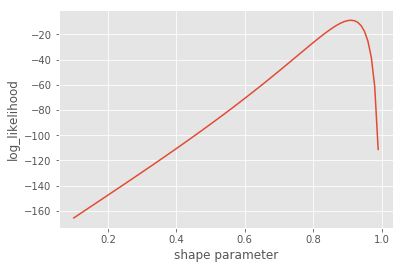

In [7]:
# plots now
from random import randint

loglike = np.zeros(100)
xval = np.zeros(100)

for i in range(100):
    xval[i]=0.1+i*0.01
    loglike[i] = log_wclikelihood(new_data,xval[i],0)
    

plt.plot(xval,loglike)
plt.ylabel("log_likelihood")
plt.xlabel("shape parameter")
plt.show()


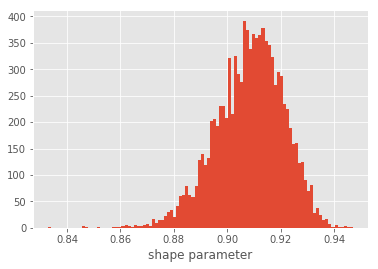

In [8]:
plt.hist(A,bins=100)
plt.xlabel("shape parameter")
plt.show()


In [9]:
# convergence

guess = 0.9# initial guess for shape
def mh(guess):
# Prepare storing MCMC chain as array of arrays.
    A = [guess]
    # define stepsize of MCMC.
    stepsizes = 0.035  # array of stepsizes
    old_theta=guess# define initial values for theta 
    accepted  = 0.0
    old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
    old_logtarget=old_loglik
# Metropolis-Hastings with 10,000 iterations.
    for p in range(10000):
        new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
        #add the restraints on new_theta
        if new_theta<0:
            continue
        new_loglik = log_wclikelihood(new_data,new_theta,0)
        new_logtarget=new_loglik
    # Accept new candidate in Monte-Carlo fashing.
        if (new_logtarget > old_logtarget):
            A.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
            old_logtarget=new_logtarget
        else:
            u = random.uniform(0.0,1.0)
            if (u < math.exp(new_logtarget-old_logtarget)):
                A.append(new_theta)
                accepted = accepted + 1.0  # monitor acceptance
                old_loglik=new_loglik
                old_theta=new_theta
                old_logtarget=new_logtarget 
            else:
                A.append(old_theta)
    print("Acceptance rate = "+str(accepted/10000.0))
    return A

In [10]:
nchains=5 #the number of chains
sampless_shape = [mh(theta) for theta in np.linspace(0.1,0.99,nchains)]# 5 mh chains for shape keeping the scale fixed at 2 and varying 
# the starting points for the scale from 0.5 to 3               # should consider replacing 5 with a letter determining the number of chains

Acceptance rate = 0.3825
Acceptance rate = 0.397
Acceptance rate = 0.3975
Acceptance rate = 0.392
Acceptance rate = 0.39


In [11]:
# x: data cell array
# m: no of chains run
# Within Chain Variance 
m=nchains
ssq_shape=np.zeros(m)
for j in range(0,m):
    ssq_shape[j]=np.var(sampless_shape[j])    
Wvar_shape=np.mean(ssq_shape)

In [12]:
# Between Chain Variance
schain_shape=0
chainlng_shape=len(sampless_shape[0])
for j in range(0,m):
    schain_shape = schain_shape + np.mean(sampless_shape[j])
mubar2_shape = (1/m)*schain_shape
bs_shape=0
for j in range(0,m):
    bs_shape=bs_shape+(np.mean(sampless_shape[j])-mubar2_shape)**2
Bvar_shape = (chainlng_shape/(m-1))*bs_shape
# Estimated variance
muvar_shape = (1-1/chainlng_shape)*Wvar_shape + (1/chainlng_shape)*Bvar_shape

# Potential Scale Reduction Factor
R_shape = np.sqrt(muvar_shape/Wvar_shape) 

print(R_shape)# smaller than 1.1, so the chain has converged.

1.00099990521


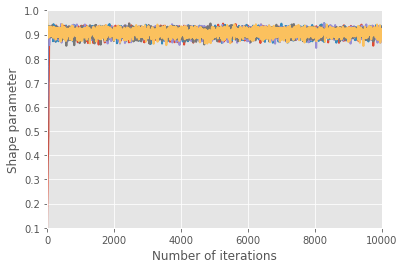

In [13]:
# Convergence of multiple chains for scale

for samples in sampless_shape:
    plt.plot(samples,lw=2)
plt.xlim([0, 10000])
plt.ylim([0.1,1])
plt.ylabel("Shape parameter")
plt.xlabel("Number of iterations")
plt.show()